# Figure 4 Supplement

Pip installation of required packages

In [1]:
#%%capture
#!pip install scanpy adjustText progressbar2 more_itertools leidenalg

In [1]:
%reload_ext autoreload
%autoreload 2
%timeit

# Add repo path to system path if it is not already there
# This allows us to import the package
import sys
GIT_REPO_PATH = "/home/jupyter/github_repos/"
if GIT_REPO_PATH not in sys.path: sys.path.append(GIT_REPO_PATH)

# Set global configuration
!git config --global user.email daniel.charytonowicz@icahn.mssm.edu
!git config --global user.name dchary

# Remove the repo if it exists
#!rm -r /content/external_data/github_"repos/unicell2/
!mkdir /home/jupyter/github_repos/

# Import base packages required
import sys, os, scipy, random, gc, warnings, re, anndata
import numpy as np
import pandas as pd
import scanpy as sc
from importlib import reload
from tqdm.auto import tqdm
import tensorflow as tf
import textwrap
import matplotlib as mpl
import matplotlib.pyplot as plt
import xenaPython as xena
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import json
import ucdeconvolve as ucd
import seaborn as sns

mkdir: cannot create directory ‘/home/jupyter/github_repos/’: File exists


/opt/conda/lib/python3.7/site-packages/xenaPython/__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))
2022-06-22 16:38:24.108851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:38:24.184281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:38:24.184914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:38:24.187264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

In [2]:
# Load the unicell basemodel
modelpath = "/home/jupyter/data/unicell_deconvolve_v2.2_10M.h5"
basemodel = tf.keras.models.load_model(modelpath, custom_objects={'tf': tf}, compile = False)

/opt/conda/lib/python3.7/site-packages/keras/layers/core.py:1045: UserWarning: unicell.tensorflow.deconvolve.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


---

# Download TCGA Data

---

In [3]:
# Load TCGA project codes
TCGA_CODES = pd.read_table("data/tcga/tcga_codes.txt", sep = ",", header=None)[0].tolist()

In [4]:
def download_TCGA(project = 'LUAD'):
    try:
        """
        Utility function that downloads given TCGA data from xenahub server.

        :param project: str - the string identifier for TCGA data.

        :return: annotated dataset with all of the genomic data.
        """

        # Define target datasets    
        hub = "https://tcga.xenahubs.net"
        dataset_exp = f"TCGA.{project}.sampleMap/HiSeqV2"
        dataset_surv = f"survival/{project}_survival.txt"

        # Get cohort name
        cohort_name = json.loads(xena.dataset_metadata(hub, dataset_surv)[0]['text'])['cohort']

        # Get patient samples from given project
        samples = xena.dataset_samples(hub, dataset_exp, None)

        # Get the genes we want to return
        genes = xena.dataset_field(hub, dataset_exp)

        # Get raw expression data from xenaHub
        _, exp = xena.dataset_probe_values(hub, dataset_exp, samples, genes)

        # Format json response into a usable dataframe
        exp = pd.DataFrame(exp, index = genes, columns = samples).T

        # Prepare clinical metadata
        probes = xena.dataset_field(hub, dataset_surv)
        data_clinical = pd.DataFrame(xena.dataset_fetch(hub, dataset_surv, samples, probes), columns = samples, index = probes).T
        data_clinical = data_clinical.astype(float)
        data_clinical['project'] = project

        # Build final annotate dataset
        adata = anndata.AnnData(exp, obs = data_clinical)

        # Return result
        return adata
    except Exception as e:
        print(e)
        return None

In [5]:
with ProcessPoolExecutor(max_workers = 8) as executor:
    adatas = list(tqdm(executor.map(download_TCGA, TCGA_CODES)))
adata_tcga = sc.concat([a for a in adatas if a])
adata_tcga.write_h5ad("data/tcga/adata_tcga.h5ad")

0it [00:00, ?it/s]

list index out of range
list index out of range
list index out of range
list index out of range


---

# Download GTEx Data

---

In [65]:
%%bash
cd /home/jupyter/manuscript/figure4/data/gtex/

aria2c https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/gtex_RSEM_Hugo_norm_count.gz
aria2c https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/GTEX_phenotype.gz

Process is terminated.


In [ ]:
data = pd.read_table("data/gtex/gtex_RSEM_Hugo_norm_count.gz", sep = "\t")
data = data.rename(columns = {'sample' : 'symbol'}).set_index('symbol').T
data.index.name = 'sampleID'

phenotypes = pd.read_table("data/gtex/GTEX_phenotype.gz", sep = "\t").rename(columns = {'Sample' : 'sampleID'}).set_index('sampleID')
phenotypes = phenotypes.reindex(data.index)

adata_gtex = anndata.AnnData(data, obs = phenotypes)
adata_gtex.write_h5ad("data/gtex/adata_gtex.h5ad")

# Run Predictions for GTEx and TCGA

In [ ]:
# Load raw data
adata_tcga = sc.read_h5ad("data/tcga/adata_tcga.h5ad")
adata_gtex = sc.read_h5ad("data/gtex/adata_gtex.h5ad")

# Run predictions
_, _, ucd_tcga_cancer = ucd.tl.deconvolve(adata_tcga, basemodel, split = True, propagate = True)
_, _, ucd_gtex_cancer = ucd.tl.deconvolve(adata_gtex, basemodel, split = True, propagate = True)

# Save results
adata_tcga.write_h5ad("data/tcga/adata_tcga_preds.h5ad")
adata_gtex.write_h5ad("data/gtex/adata_gtex_preds.h5ad")

In [ ]:
adata_gtex = sc.read_h5ad("data/gtex/adata_gtex.h5ad")

# Run predictions
ucd.tl.deconvolve(adata_gtex, basemodel, split = False, propagate = False)

In [12]:
liver_data = ucd.utils.extract(adata_gtex, cat = 'all').loc[adata_gtex.obs['_primary_site'].eq('Liver')]

In [16]:
expl_lc = ucd.tl.explain(adata_gtex, ['lihc', 'hcc'], basemodel)

Explaining Batches |   0% (0 of 245) |   | Elapsed Time: 0:00:00 ETA:  --:--:--2022-06-22 16:46:01.604368: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x561c67f1a010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-22 16:46:01.604607: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2022-06-22 16:46:01.786329: W tensorflow/compiler/tf2xla/kernels/categorical_op.cc:133] Warning: Using tf.random.categorical with XLA compilation will ignore seeds.
2022-06-22 16:46:01.929100: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-06-22 16:46:16.057181: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Explaining Batches | 100% (245 of 245) |#| Elapsed Time: 0:

In [22]:
expl_lc.loc['hcc'].loc[adata_gtex.obs['_primary_site'].eq('Liver')].mean(0).sort_values(ascending = False).head(30)

ORM2        0.179650
APOA2       0.144105
FGL1        0.134662
SAA4        0.134451
HPD         0.127623
ALB         0.117973
HPX         0.115823
CYP2C9      0.113817
ORM1        0.088832
CES1        0.083351
APCS        0.072494
UGT2B4      0.069096
MTATP6P1    0.068645
FGA         0.064936
C4BPA       0.058646
CFHR1       0.055109
ASGR1       0.053672
SERPINC1    0.053551
APOC3       0.052430
FGB         0.048739
HSD17B6     0.046820
AGT         0.044944
CYP4F3      0.043733
VTN         0.041583
FMO3        0.041053
ANGPTL3     0.040882
SAA2        0.039305
APOH        0.038571
CFHR3       0.038158
ADH4        0.038150
dtype: float64

In [15]:
liver_data.mean(0).sort_values(ascending = False)

lihc                                0.419940
hcc                                 0.333066
hepatocyte                          0.095516
fat stem cell                       0.054288
cd14-positive, cd16-low monocyte    0.009637
                                      ...   
bone marrow cell                    0.000000
kidney granular cell                0.000000
b-1a b cell                         0.000000
pre-natural killer cell             0.000000
                                    0.000000
Length: 842, dtype: float32

# Plot Results

In [92]:
adata_tcga = sc.read_h5ad("data/tcga/adata_tcga_preds.h5ad")
adata_gtex = sc.read_h5ad("data/gtex/adata_gtex_preds.h5ad")

## Panel A

In [123]:
data_gtex_bysite = pd.concat([ucd.utils.get_deconv_as_df(adata_gtex, category = 'cancer')['malignant cell'],
                        adata_gtex.obs['_primary_site']], axis = 1)
data_gtex_bysite = data_gtex_bysite[data_gtex_bysite['_primary_site'].ne('<not provided>')]
data_gtex_bysite['_primary_site'].cat.remove_unused_categories(inplace = True)

In [128]:
print(f"Median Non-Malignant Fraction (TCGA): {1 - ucd_tcga_cancer['malignant cell'].median()}")
print(f"Median Non-Malignant Fraction (GTEX): {1 - ucd_gtex_cancer['malignant cell'].median()}")

Median Malignant Fraction (TCGA): 0.7408732175827026
Median Malignant Fraction (GTEX): 0.9728498868644238


(4, 5)


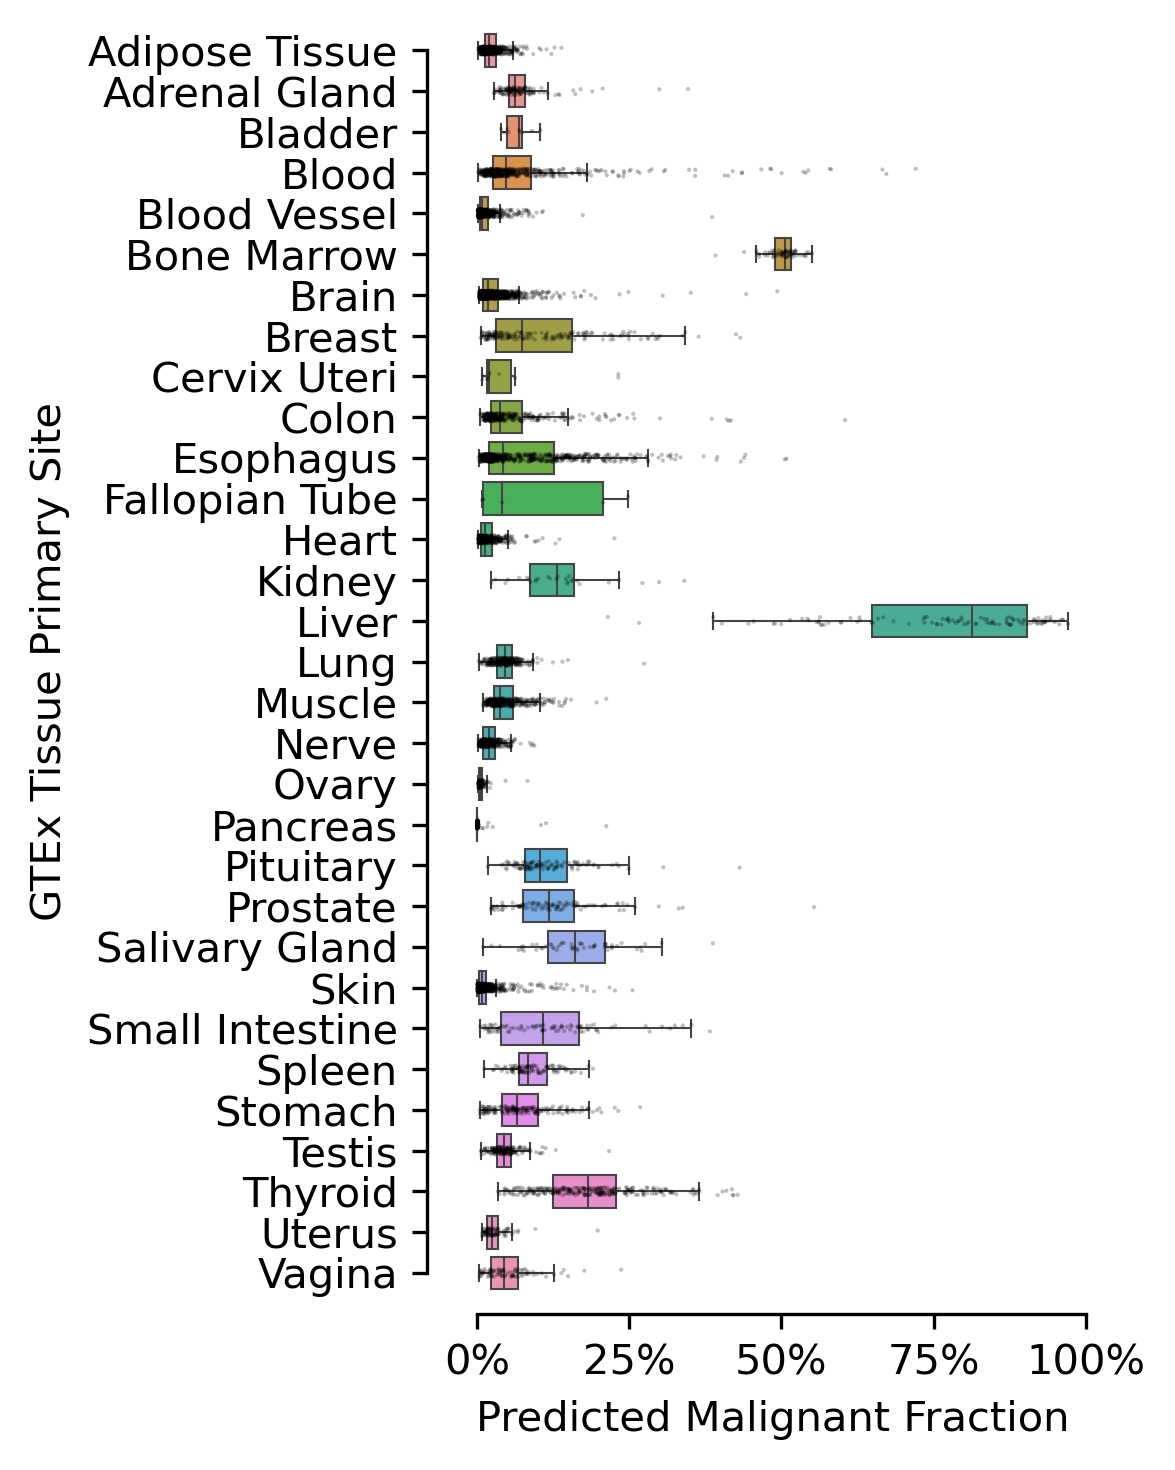

In [160]:
with ucd.pl.FigContext(dpi = 300, figsize = (4,5), despine = True) as ax:
    sns.boxplot(data = data_gtex_bysite, x = 'malignant cell', y = '_primary_site', fliersize = 0, ax = ax,
               linewidth = 0.5)
    sns.stripplot(data = data_gtex_bysite, x = 'malignant cell', y = '_primary_site', ax = ax,
                 size = 1, color = 'k', alpha = 0.25)
    ax.set_ylabel('GTEx Tissue Primary Site')
    ax.set_xlabel('Predicted Malignant Fraction')
    ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
    # Save figure
    ax.get_figure().savefig("results/supplement4_A.png", dpi = 300)

## Panel B

In [161]:
df_gtex_malig = ucd.utils.get_deconv_as_df(adata_gtex, category = 'cancer')['malignant cell'].to_frame()
df_tcga_malig = ucd.utils.get_deconv_as_df(adata_tcga, category = 'cancer')['malignant cell'].to_frame()

df_tcga_malig['dataset'] = 'TCGA'
df_gtex_malig['dataset'] = 'GTEX'

df_malig_merged = pd.concat([df_tcga_malig, df_gtex_malig])
df_malig_merged = df_malig_merged.reset_index(drop = True)

(2, 4)
GTEX vs. TCGA: Welch's t-test independent samples, P_val:0.000e+00 t=-9.476e+01


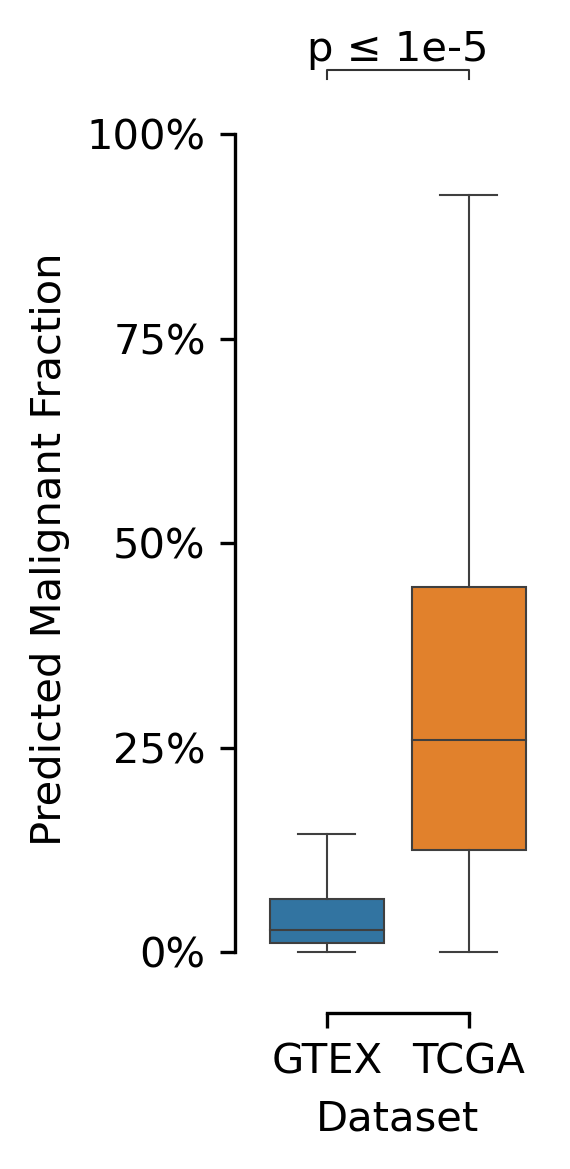

In [164]:
from statannotations.Annotator import Annotator
import textwrap

df = df_malig_merged
x = 'dataset'
y = 'malignant cell'
pairs = [('TCGA', 'GTEX')]
order = ['GTEX', 'TCGA']

with ucd.pl.FigContext(dpi = 300, figsize = (2,4), despine = True) as ax:
    sns.boxplot(data = df, x = x, y = y, fliersize = 0, 
                linewidth = 0.5, order = order, ax = ax)
    
    annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
    annotator.configure(test='t-test_welch', text_format='simple', 
                        loc='outside', comparisons_correction = None,
                       line_offset = 0.01, show_test_name = False,
                       line_height = 0.01, line_width = 0.5,
                       text_offset = 0)
    annotator.apply_and_annotate()
    
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Predicted Malignant Fraction')
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
    
    # Save figure
    ax.get_figure().savefig("results/supplement4_B.png", dpi = 300)

## Panel C

In [391]:
tcga_cancer_preds = ucd.utils.get_deconv_as_df(adata_tcga, category = 'cancer').T.iloc[2:].T
common_cancer_subtypes = list(set(adata_tcga.obs.project.str.lower().unique()).intersection(set(tcga_cancer_preds.columns)))

# Subset to common cancer subtypes
adata_tcga_sub = adata_tcga[adata_tcga.obs.project.str.lower().isin(common_cancer_subtypes)]
tcga_cancer_preds = tcga_cancer_preds.reindex(columns = common_cancer_subtypes, index = adata_tcga_sub.obs.index)
tcga_cancer_preds = (tcga_cancer_preds.T / tcga_cancer_preds.sum(1)).T

confusion_matrix = tcga_cancer_preds.groupby(adata_tcga_sub.obs.project.str.lower()).mean().reindex(tcga_cancer_preds.columns)
confusion_matrix.index = confusion_matrix.index.str.upper()
confusion_matrix.columns = confusion_matrix.columns.str.upper()

(5, 5)


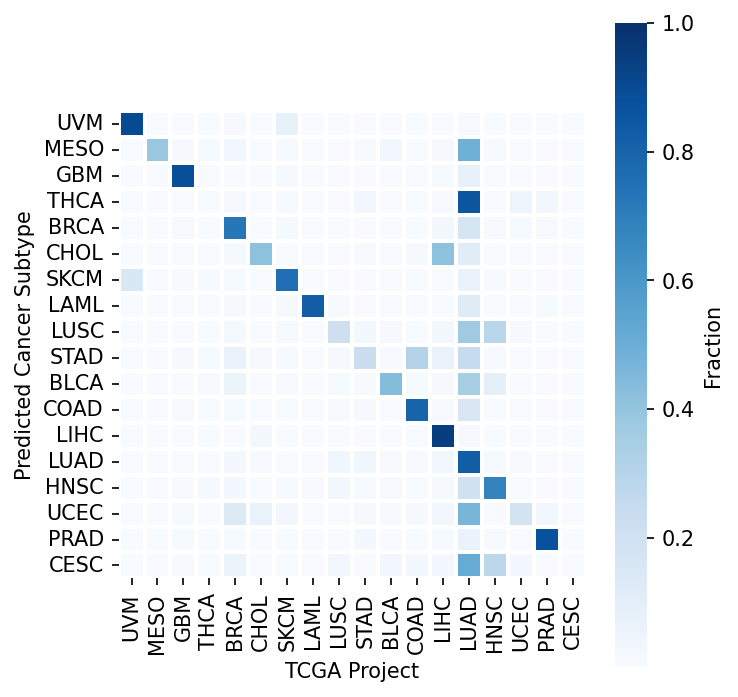

In [393]:
with ucd.pl.FigContext(dpi = 150, figsize = (5,5)) as ax:
    g = sns.heatmap(confusion_matrix, cmap = 'Blues', vmax = 1.0, ax = ax, square = True, linewidth = 1.0,
                   cbar_kws = {'label' : 'Fraction'})
    ax.set_xlabel('TCGA Project')
    ax.set_ylabel('Predicted Cancer Subtype')
    
    # Save figure
    ax.get_figure().savefig("results/supplement4_C.png", dpi = 300)

## Panel D

In [367]:
tcga_cancer_preds = ucd.utils.get_deconv_as_df(adata_tcga, category = 'cancer').T.iloc[2:].T
common_cancer_subtypes = list(set(adata_tcga.obs.project.str.lower().unique()).intersection(set(tcga_cancer_preds.columns)))

# Subset to common cancer subtypes
adata_tcga_sub = adata_tcga[adata_tcga.obs.project.str.lower().isin(common_cancer_subtypes)]
tcga_cancer_preds = tcga_cancer_preds.reindex(columns = common_cancer_subtypes, index = adata_tcga_sub.obs.index)
tcga_cancer_preds = (tcga_cancer_preds.T / tcga_cancer_preds.sum(1)).T

# Get one-hot encoding for class predictions
onehotclasses = pd.get_dummies(adata_tcga_sub.obs.project.str.lower().astype('category')).reindex(columns = common_cancer_subtypes)
onehotclasses = onehotclasses.astype(np.float32)

In [368]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

# Calculates Micro-Average AUC Score
micro_avg_auc_score = roc_auc_score(onehotclasses, tcga_cancer_preds, average = 'micro')

print(f"TCGA Micro-Average Classification AUC Score ({len(onehotclasses.columns)} Subtypes): {round(micro_avg_auc_score, 3)}")

TCGA Micro-Average Classification AUC Score (18 Subtypes): 0.889


In [369]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(ytrue, ypreds, ax, labels = None):
    
    # Convert to numpy if dataframe
    ytrue = ytrue.values if isinstance(ytrue, pd.DataFrame) else ytrue
    ypreds = ypreds.values if isinstance(ypreds, pd.DataFrame) else ypreds

    
    if ytrue.ndim == 1:
        ytrue = np.expand_dims(ytrue[:,0], 1)
    if ypreds.ndim == 1:
        ypreds = np.expand_dims(ypreds[:,0], 1)
        
    assert ypreds.shape == ytrue.shape
    
    n_classes = ypreds.shape[1]
    
    labels = list(range(n_classes)) if not labels else labels
    assert len(labels) == n_classes
        
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    
    for i,label in enumerate(labels):
        fpr[label], tpr[label], _ = roc_curve(ytrue[:, i], ypreds[:, i])
        roc_auc[label] = round(auc(fpr[label], tpr[label]),2)
    
    #fpr['Average'], tpr['Average'], _ = roc_curve(ytrue.mean(1), ypreds.mean(1))
    
    # Plot
    ax.plot([0, 1], [0, 1], 'k--', linewidth = 0.75, alpha = 0.25)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    for label in labels:
        ax.plot(fpr[label], tpr[label], label= f"{label.upper()} : {roc_auc[label]}", linewidth = 0.75)
        
    #ax.plot(fpr['Average'], tpr['Average'], label= "Average", color = 'g', linewidth = 3)
    
    ax.legend(loc="best", fontsize = 'xx-small', frameon = False)

    return fpr, tpr, roc_auc

(4, 4)


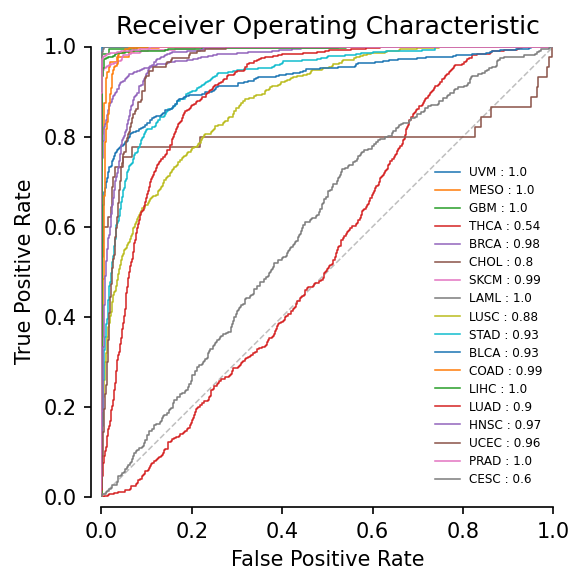

In [370]:
with ucd.pl.FigContext(dpi = 150, figsize = (4,4), despine = True) as ax:
    fpr, tpr, roc_auc = plot_roc_curve(onehotclasses, tcga_cancer_preds, ax = ax, labels = onehotclasses.columns.tolist())
    
    # Save figure
    ax.get_figure().savefig("results/supplement4_D.png", dpi = 300)

## Panel E

In [397]:
tcga_primary_preds = ucd.utils.get_deconv_as_df(adata_tcga, category = 'primary').T.iloc[2:].T

In [407]:
df = pd.concat([tcga_primary_preds['leukocyte'], adata_tcga.obs.project], axis = 1)
order = df.groupby('project').leukocyte.mean().sort_values(ascending = False).index.tolist()

(12, 4)


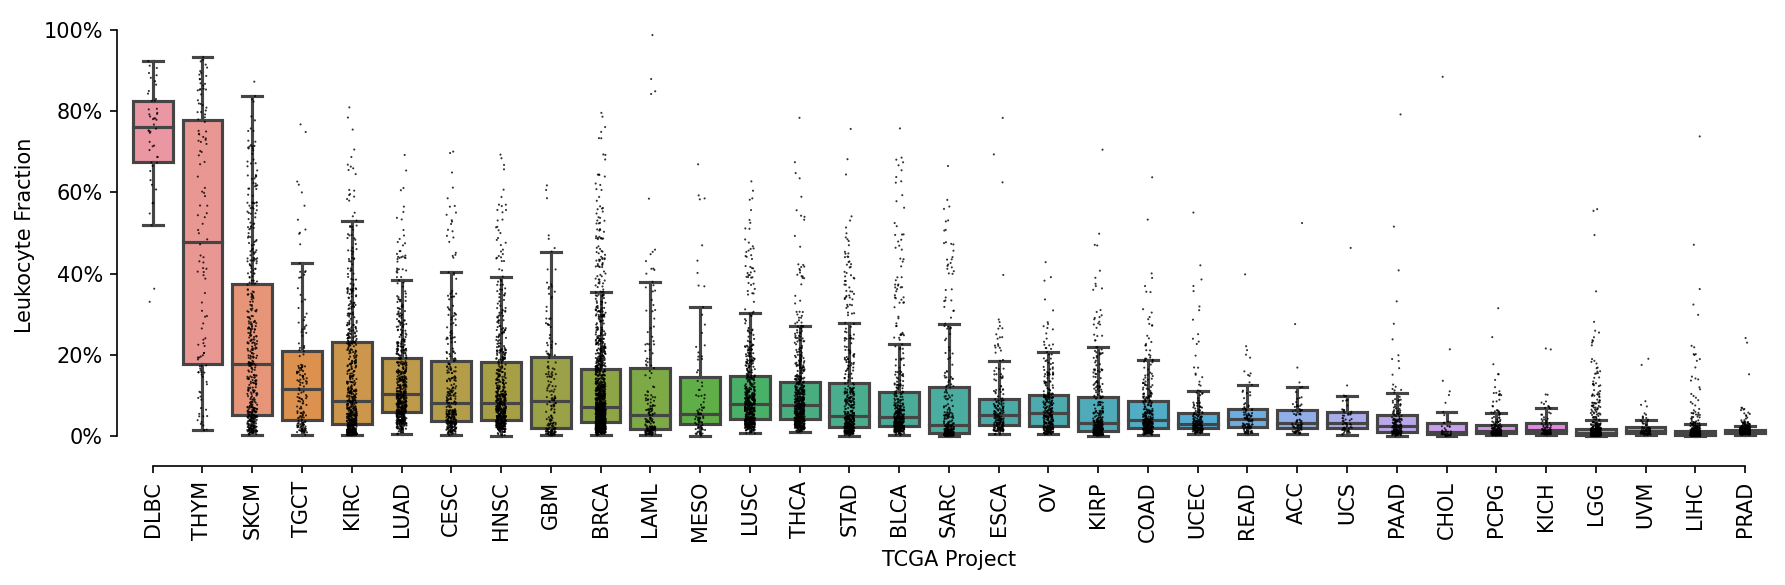

In [426]:
with ucd.pl.FigContext(dpi = 150, figsize = (12,4), despine = True) as ax:
    sns.boxplot(data = df, x = 'project', y = 'leukocyte', order = order, fliersize = 0.0, ax = ax)
    sns.stripplot(data = df, x = 'project', y = 'leukocyte', order = order, size = 1, color = 'k', ax = ax, alpha = 0.8)

    ax.xaxis.set_tick_params(which = 'both', rotation = 90)
    ax.set_ylabel('Leukocyte Fraction')
    ax.set_xlabel('TCGA Project')
    
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
    
    # Save figure
    ax.get_figure().savefig("results/supplement4_E.png", dpi = 300)

# Feature Attributions

In [3]:
import xarray as xr

# Reload saved data
expression_xr = xr.open_dataarray("/home/jupyter/unicell_tde_expression_xr.nc")
explanations_cellcounts = pd.read_hdf("/home/jupyter/unicell_tde_explanations_cellcounts.h5", key = "X")

/opt/conda/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "
/opt/conda/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [110]:
explanations_cellcounts.sum()

28087862.0

In [255]:
top = explanations_df_cancer.apply(lambda x : x.sort_values(ascending = False).iloc[0:5], axis = 1).fillna(0.0)

Text(0.5, 214.16666666666666, 'Genes')

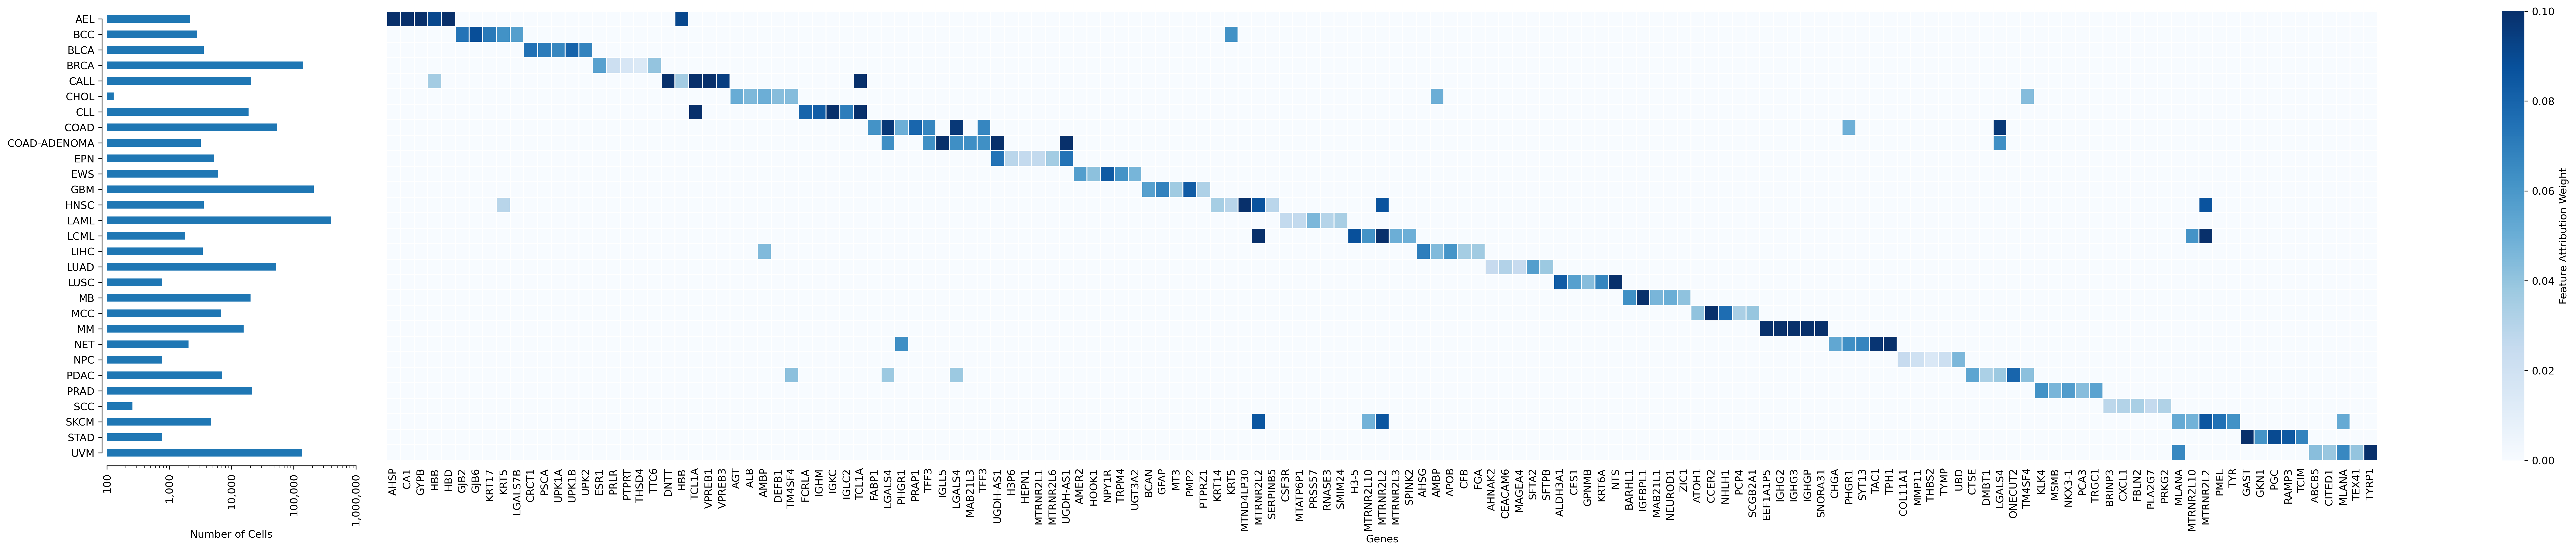

In [256]:
fig, axes = plt.subplots(1,2, figsize = (48,8),gridspec_kw={'width_ratios' : [3, 30], 'wspace' : 0.0225}, dpi = 300, sharey = False)

from more_itertools import collapse
genes_ordered = []
for gene, row in top.iterrows():
    genes_ordered.append(row[row > 0.0].index.tolist())
genes_ordered = list(collapse(genes_ordered))

#explanations_cellcounts_cancer.reindex(list(map(lambda x : x.get_text(), cg.ax_heatmap.get_yticklabels())))
explanations_cellcounts_cancer.index = explanations_cellcounts_cancer.index.str.upper()
explanations_cellcounts_cancer.plot.barh(ax = axes[0])

axes[0].invert_yaxis()
axes[0].set_xscale('log')
axes[0].set_xlim(100, 1000000)
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axes[0].set_yticklabels(axes[0].get_yticklabels())
sns.despine(ax = axes[0], offset = 5, trim = True)

cg = sns.heatmap(top.T.loc[genes_ordered].T, yticklabels = False, xticklabels = True,
               cmap = 'Blues', linewidth = 0.5, vmin = 0, vmax = 0.1, center = 0.05, ax = axes[1])
cg.collections[0].colorbar.set_label("Feature Attribution Weight")
axes[1].xaxis.set_tick_params(bottom = False)

axes[0].set_xlabel("Number of Cells")
axes[1].set_xlabel("Genes")